In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# The following are imported to read "201902-citibike-tripdata.csv.zip" through url which contains multiple files
import requests
import io
from zipfile import ZipFile

In [2]:
# Basic url for downloadable files of Citi Bike trip data
basic_url = 'https://s3.amazonaws.com/tripdata/'

# List of urls (second half) for specific .zip files
file_url_list = [
    "201706-citibike-tripdata.csv.zip", "201707-citibike-tripdata.csv.zip", "201708-citibike-tripdata.csv.zip", 
    "201709-citibike-tripdata.csv.zip", "201710-citibike-tripdata.csv.zip", "201711-citibike-tripdata.csv.zip",
    "201712-citibike-tripdata.csv.zip", "201801-citibike-tripdata.csv.zip", "201802-citibike-tripdata.csv.zip", 
    "201803-citibike-tripdata.csv.zip", "201804-citibike-tripdata.csv.zip", "201805-citibike-tripdata.csv.zip",
    "201806-citibike-tripdata.csv.zip", "201807-citibike-tripdata.csv.zip", "201808-citibike-tripdata.csv.zip",
    "201809-citibike-tripdata.csv.zip", "201810-citibike-tripdata.csv.zip", "201811-citibike-tripdata.csv.zip",
    "201812-citibike-tripdata.csv.zip", "201901-citibike-tripdata.csv.zip", "201902-citibike-tripdata.csv.zip",
    "201903-citibike-tripdata.csv.zip", "201904-citibike-tripdata.csv.zip", "201905-citibike-tripdata.csv.zip"
]

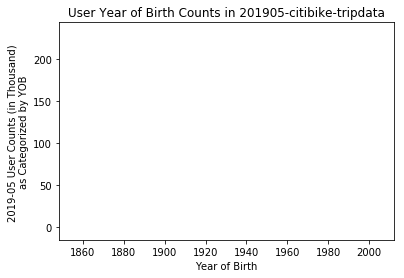

In [3]:
# Loop through "file_url_list"
for file_url in file_url_list:
    
    # .......... READ DATA .......... #
    # Concatenate "basic_url" and "file_url" to make request url
    url = basic_url + file_url
    
    # Multiple files are found in "201902-citibike-tripdata.csv.zip"
    if file_url == "201902-citibike-tripdata.csv.zip":
        # https://stackoverflow.com/questions/9419162/download-returned-zip-file-from-url
        # https://stackoverflow.com/questions/44575251/reading-multiple-files-contained-in-a-zip-file-with-pandas?rq=1
        response = requests.get(url)
        zip_file = ZipFile(io.BytesIO(response.content))
        # Read monthly trip data into Pandas DataFrame
        monthly_trip_df = pd.read_csv(zip_file.open("201902-citibike-tripdata.csv"))        
    else:
        # Read monthly trip data into Pandas DataFrame
        monthly_trip_df = pd.read_csv(url)        
    
    # .......... DATA CLEANING .......... # 
    # 1. Delete unnecessary columns in the circumstance that station id info is generated separately
    monthly_trip_df.drop(["start station name", "start station latitude", "start station longitude",
        "end station name", "end station latitude", "end station longitude"], axis=1, inplace=True)
    
    # Rename column names
    monthly_trip_df = monthly_trip_df.rename(columns = {
        "tripduration": "trip-dur",
        "starttime": "s-date-time",
        "stoptime": "e-date-time",
        "start station id": "s-sta-id",
        "end station id": "e-sta-id",
        "bikeid": "bike-id",
        "usertype": "user",
        "birth year": "yob"
    })
    
    # 2. Replace np.nan in "yob" column with data
    # Note that it can only be from the customer side should there be any BIZARRE input in the data
    # Also note that direct iterating and manipulating on "monthly_trip_df" will take forever
    # Convert "yob" column to list
    yob_list = monthly_trip_df["yob"].tolist()

    # Variable to determine if deleting and resetting of "yob" column is necessary
    yob_nan = "F"

    # Change np.nan to 1900 in "yob_list", assuming that no person born in 1900 would be able to use Citi Bike
    for i in range(len(yob_list)):
        if np.isnan(yob_list[i]):
            yob_list[i] = 1900
            yob_nan = "T"

    # If any value (np.nan) within "yob_list" has been changed to 1900, execute the following codes ...
    if yob_nan == "T":
        # Delete "yob" column
        monthly_trip_df.drop(["yob"], axis=1, inplace=True)
        # Set "yob_list" as new "yob" column of "monthly_trip_df"
        monthly_trip_df["yob"] = yob_list
        
    # 3. Change the data type of columns to save memory usage
    monthly_trip_df["trip-dur"] = monthly_trip_df["trip-dur"].astype("int32")
    monthly_trip_df["bike-id"] = monthly_trip_df["bike-id"].astype("int32")
    monthly_trip_df["yob"] = monthly_trip_df["yob"].astype("int16")
    monthly_trip_df["gender"] = monthly_trip_df["gender"].astype("int8")        
    # For some monthly trip data like 201808, "s-sta-id" and "e-sta-id" have the same indices that lack station id
    # It took more than 10 min yet without success in deleting such records in previous pilot test for a single monthly data
    # The amounts of such records only account for roughly 0.1% of all data
    # In this scenario, I skip deleting such records for the sake of performance efficiency
    try:
        # If np.nan is in either "s-sta-id" or "e-sta-id" column, skip changing column data type
        monthly_trip_df["s-sta-id"] = monthly_trip_df["s-sta-id"].astype("int16")
        monthly_trip_df["e-sta-id"] = monthly_trip_df["e-sta-id"].astype("int16")
    except ValueError:
        pass
    
    # 4. Leave only "yyyy-mm-dd HH/MM/SS" for "s-date-time" and "e-date-time"
    # Convert "s-date-time" and "e-date-time" columns to lists
    s_list = monthly_trip_df["s-date-time"].tolist()
    e_list = monthly_trip_df["e-date-time"].tolist()

    # Change values in lists of start/end time and date
    for i in range(len(s_list)):
        s_list[i] = s_list[i][:19]
        e_list[i] = e_list[i][:19]

    # Remove "s-date-time" and "e-date-time" columns from "monthly_trip_df"
    monthly_trip_df.drop(["s-date-time", "e-date-time"], 1, inplace=True) 

    # Add new columns in "monthly_trip_df" for start/end time and date
    monthly_trip_df["s-date-time"] = s_list
    monthly_trip_df["e-date-time"] = e_list

    # Reorganize the columns of "monthly_trip_df"
    monthly_trip_df = monthly_trip_df[["s-date-time", "s-sta-id", "e-date-time", "e-sta-id", "trip-dur", "bike-id",
        "user", "yob", "gender"]]
        
    # Only save entire monthly trip data that are newer than March 2019
    if int(file_url[:6]) > 201903:
        # Save "monthly_trip_df" as csv file
        monthly_trip_df.to_csv(f"../data/cleaned_data/{file_url[:-8]}.csv", index=False, header=True) 
        
    # .......... USER YOB COUNTS .......... #
    # Dict for user age count
    yob_ct = {}

    # Keys in "yob_ct" 
    for yr in range(monthly_trip_df["yob"].min(), monthly_trip_df["yob"].max() + 1):
        # Set init value of all keys to 0
        yob_ct[yr] = 0

    # Calculate counts for each year of birth as provided by users
    for yr in monthly_trip_df["yob"]:
        # Add 1 to designated key(year) of "yob_ct" during iteration (unit: thousand)
        yob_ct[yr] += .001   
    
    # Plot age counts results
    s_plot = plt.scatter(list(yob_ct.keys()), list(yob_ct.values()))

    # Create title
    plt.title(f"User Year of Birth Counts in {file_url[:-8]}")

    # Backslash new line
    nl = '\n'

    # Create labels for x and y axes
    plt.xlabel("Year of Birth")
    plt.ylabel(f"{file_url[:4]}-{file_url[4:6]} User Counts (in Thousand) {nl}as Categorized by YOB")

    # Save figure
    plt.savefig(f"../data/figures/User Year of Birth Counts in {file_url[:-8]}", dpi=300)
    
    # Remove the artist "s_plot"
    s_plot.remove()
   
    # .......... YOB 1969 .......... #    
    # Create new dataframes that w/o "yob" of 1969
    trip_1969_df = monthly_trip_df.loc[monthly_trip_df["yob"] == 1969, :].reset_index()
    trip_no_1969_df = monthly_trip_df.loc[monthly_trip_df["yob"] != 1969, :].reset_index()

    # Variables to store Customer and Subscriber counts
    cus_ct_1969 = trip_1969_df.groupby("user").count()["yob"].tolist()[0]
    sub_ct_1969 = trip_1969_df.groupby("user").count()["yob"].tolist()[1]
    cus_ct_no_1969 = trip_no_1969_df.groupby("user").count()["yob"].tolist()[0]
    sub_ct_no_1969 = trip_no_1969_df.groupby("user").count()["yob"].tolist()[1]
    
    # Read "yob1969_df"
    yob1969_df = pd.read_csv("../data/cleaned_data/yob1969-citibike-tripdata.csv")
    
    # Get current length of "yob1969_df"
    index = len(yob1969_df)
 
    # Note that a list's length equals to the maximum index plus 1
    yob1969_df.loc[index, "data-month"] = file_url[:6]
    yob1969_df.loc[index, "yob-1969"] = "T"
    yob1969_df.loc[index, "cus-ct"] = cus_ct_1969
    yob1969_df.loc[index, "sub-ct"] = sub_ct_1969
    yob1969_df.loc[index, "yob-nan"] = yob_nan
    yob1969_df.loc[index + 1, "data-month"] = file_url[:6]
    yob1969_df.loc[index + 1, "yob-1969"] = "F"
    yob1969_df.loc[index + 1, "cus-ct"] = cus_ct_no_1969
    yob1969_df.loc[index + 1, "sub-ct"] = sub_ct_no_1969
    yob1969_df.loc[index + 1, "yob-nan"] = yob_nan
    
    # Save "yob1969_df" as csv file
    yob1969_df.to_csv("../data/cleaned_data/yob1969-citibike-tripdata.csv", index=False, header=True)        